We get shit done 

In [1]:
import pandas as pd
import numpy as np 
# for data preparation
import matplotlib.pyplot as plt 
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns 

# for preprocessing pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pickle
import matplotlib.pyplot as plt
import os

# for model training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import time



In [2]:
# Set plot style and size for graphing and visualizations
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [3]:
df = pd.read_csv('email_phishing_data.csv')
df

,num_words,num_unique_words,num_stopwords,num_links,num_unique_domains,num_email_addresses,num_spelling_errors,num_urgent_keywords,label
0,140,94,52,0,0,0,0,0,0
1,5,5,1,0,0,0,0,0,0
2,34,32,15,0,0,0,0,0,0
3,6,6,2,0,0,0,0,0,0
4,9,9,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
524841,782,327,301,2,2,2,52,1,0
524842,36,30,11,0,0,0,4,0,1
524843,61,46,11,0,0,0,3,0,0
524844,213,136,89,0,0,0,18,0,0


Start of data exploration

In [4]:
# adds another column by converting label to is_phising for better readability (0 = safe, 1 = phishing)
df['is_phishing'] = df['label'].astype(bool)
# dropping label
df = df.drop('label', axis= 1)
print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns")
df

Dataset loaded with 524846 rows and 9 columns


,num_words,num_unique_words,num_stopwords,num_links,num_unique_domains,num_email_addresses,num_spelling_errors,num_urgent_keywords,is_phishing
0,140,94,52,0,0,0,0,0,False
1,5,5,1,0,0,0,0,0,False
2,34,32,15,0,0,0,0,0,False
3,6,6,2,0,0,0,0,0,False
4,9,9,2,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...
524841,782,327,301,2,2,2,52,1,False
524842,36,30,11,0,0,0,4,0,True
524843,61,46,11,0,0,0,3,0,False
524844,213,136,89,0,0,0,18,0,False


In [5]:
"""Display basic information about the dataset"""
print("\n=== Dataset Overview ===")
print(f"Dataset shape: {df.shape}")
print("\nFeature statistics:")
print(df.describe().T)

print("\nMissing values:")
print(df.isnull().sum())

print("\nTarget variable distribution:")
print(df['is_phishing'].value_counts())
print(f"Percentage of phishing emails: {df['is_phishing'].mean()*100:.2f}%")


=== Dataset Overview ===
Dataset shape: (524846, 9)

Feature statistics:
                        count        mean          std  min   25%    50%  \
num_words            524846.0  276.228000  3335.456750  0.0  47.0  120.0   
num_unique_words     524846.0  123.012167   201.626478  0.0  38.0   79.0   
num_stopwords        524846.0   80.045465  1023.330380  0.0  12.0   34.0   
num_links            524846.0    0.895588     5.603001  0.0   0.0    0.0   
num_unique_domains   524846.0    0.347767     1.774209  0.0   0.0    0.0   
num_email_addresses  524846.0    2.114897    13.592682  0.0   0.0    0.0   
num_spelling_errors  524846.0   24.694731   311.312358  0.0   2.0    8.0   
num_urgent_keywords  524846.0    0.245301     0.559320  0.0   0.0    0.0   

                       75%        max  
num_words            269.0  2339682.0  
num_unique_words     145.0    51251.0  
num_stopwords         79.0   720411.0  
num_links              0.0      824.0  
num_unique_domains     0.0      524.0  
n

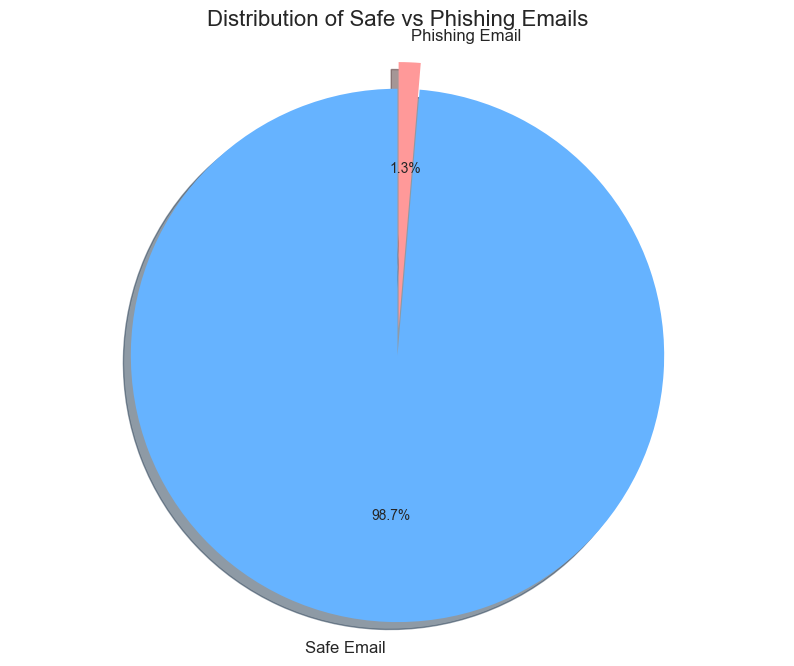

In [6]:
"""Create a pie chart for the target variable distribution"""
plt.figure(figsize=(10, 8))
target_counts = df['is_phishing'].value_counts()
labels = ['Safe Email', 'Phishing Email']
colors = ['#66b3ff', '#ff9999']
explode = (0.1, 0)  # explode the 1st slice (Safe)

plt.pie(target_counts, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Safe vs Phishing Emails', fontsize=16)
plt.savefig('data exploration results/target_distribution_pie.png', dpi=300, bbox_inches='tight')
plt.show()

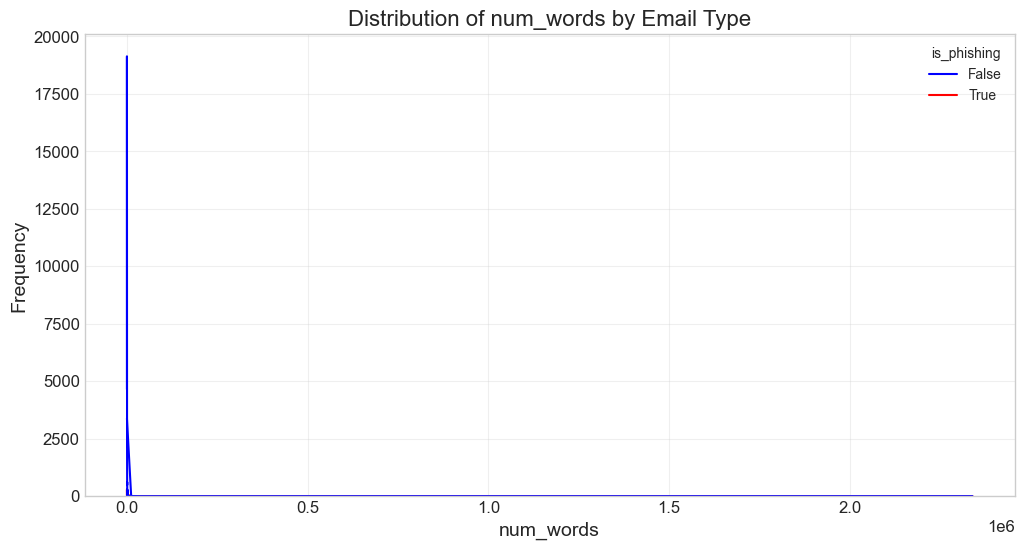

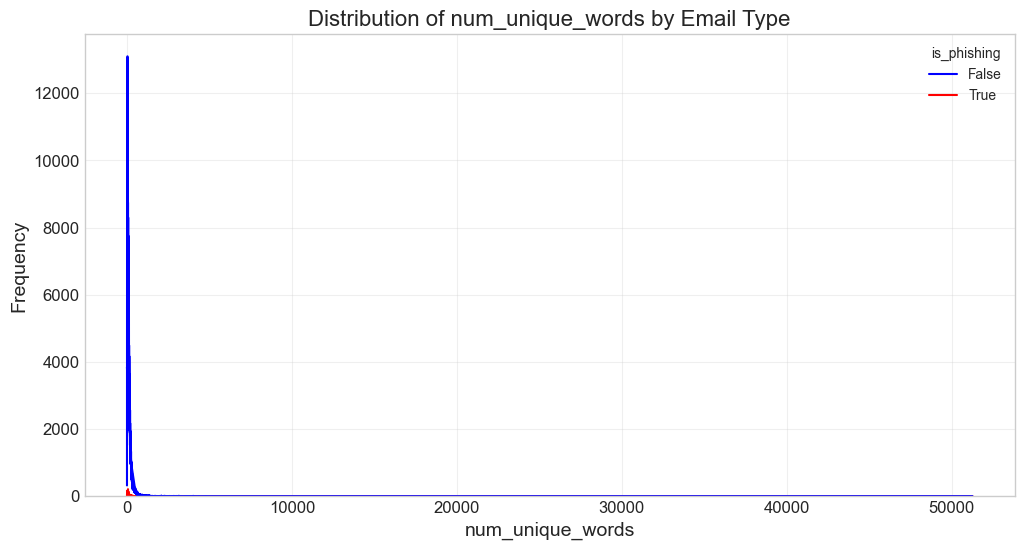

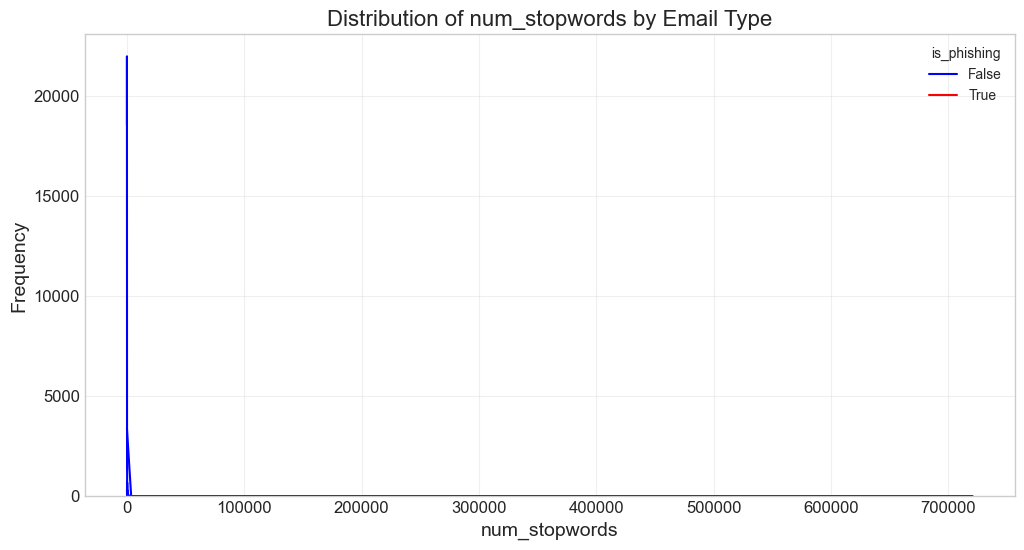

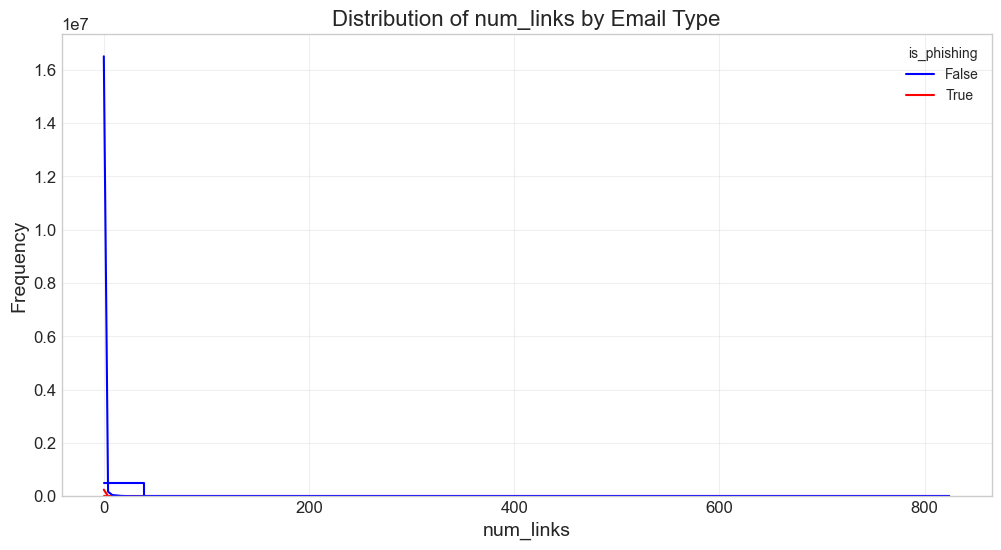

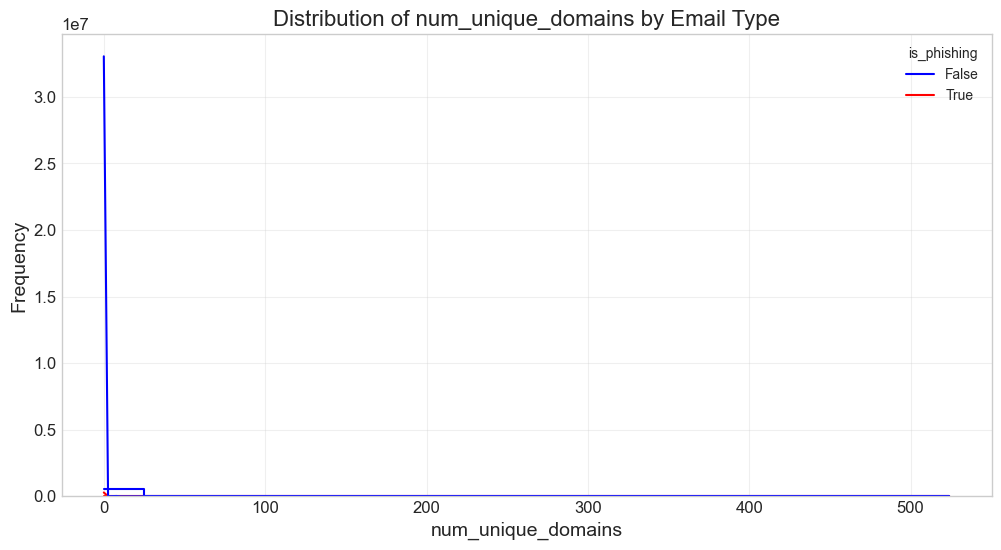

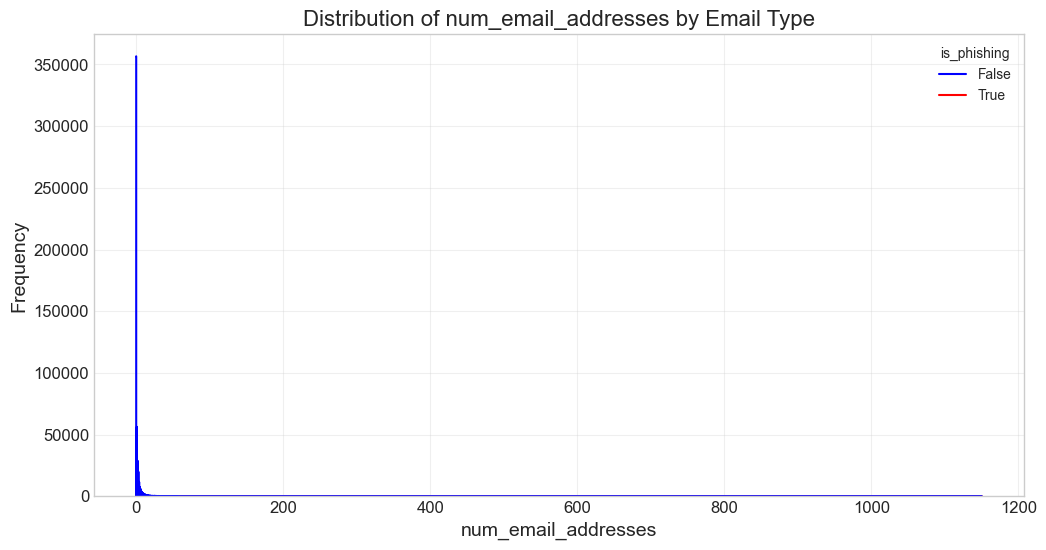

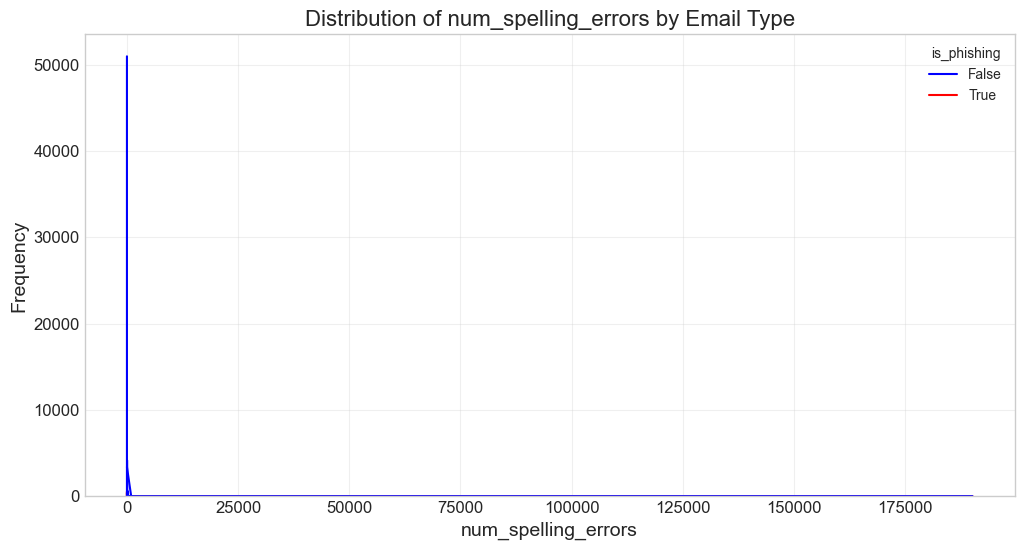

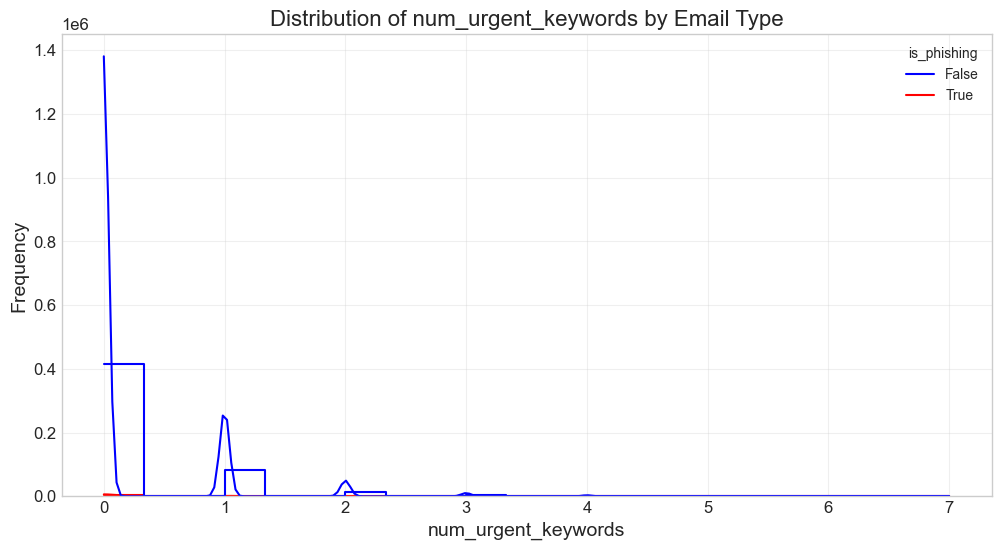

In [7]:
"""Create histograms for each feature separated by target class"""
features = [col for col in df.columns if col not in ['label', 'is_phishing']]

# Create histograms for each feature
for feature in features:
    plt.figure(figsize=(12, 6))
    
    # Plot histogram with density curve for each class
    sns.histplot(data=df, x=feature, hue='is_phishing', kde=True, 
                    element='step', palette=['blue', 'red'], 
                    hue_order=[False, True], fill=False)
    
    plt.title(f'Distribution of {feature} by Email Type', fontsize=16)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.savefig(f'data exploration results/distribution_{feature}.png', dpi=300, bbox_inches='tight')
    plt.show()


=== Outlier Analysis ===
num_words: 46375 outliers detected
num_unique_words: 36226 outliers detected
num_stopwords: 45847 outliers detected
num_links: 93422 outliers detected
num_unique_domains: 93422 outliers detected
num_email_addresses: 76327 outliers detected
num_spelling_errors: 52217 outliers detected
num_urgent_keywords: 103013 outliers detected


C:\Users\Admin\AppData\Local\Temp\ipykernel_15240\1007727474.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_phishing', y=feature, data=df, palette=['#66b3ff', '#ff9999'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_15240\1007727474.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_phishing', y=feature, data=df, palette=['#66b3ff', '#ff9999'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_15240\1007727474.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_phishing', y=feature, data=df, palette=['#66b3ff', '#ff9999']

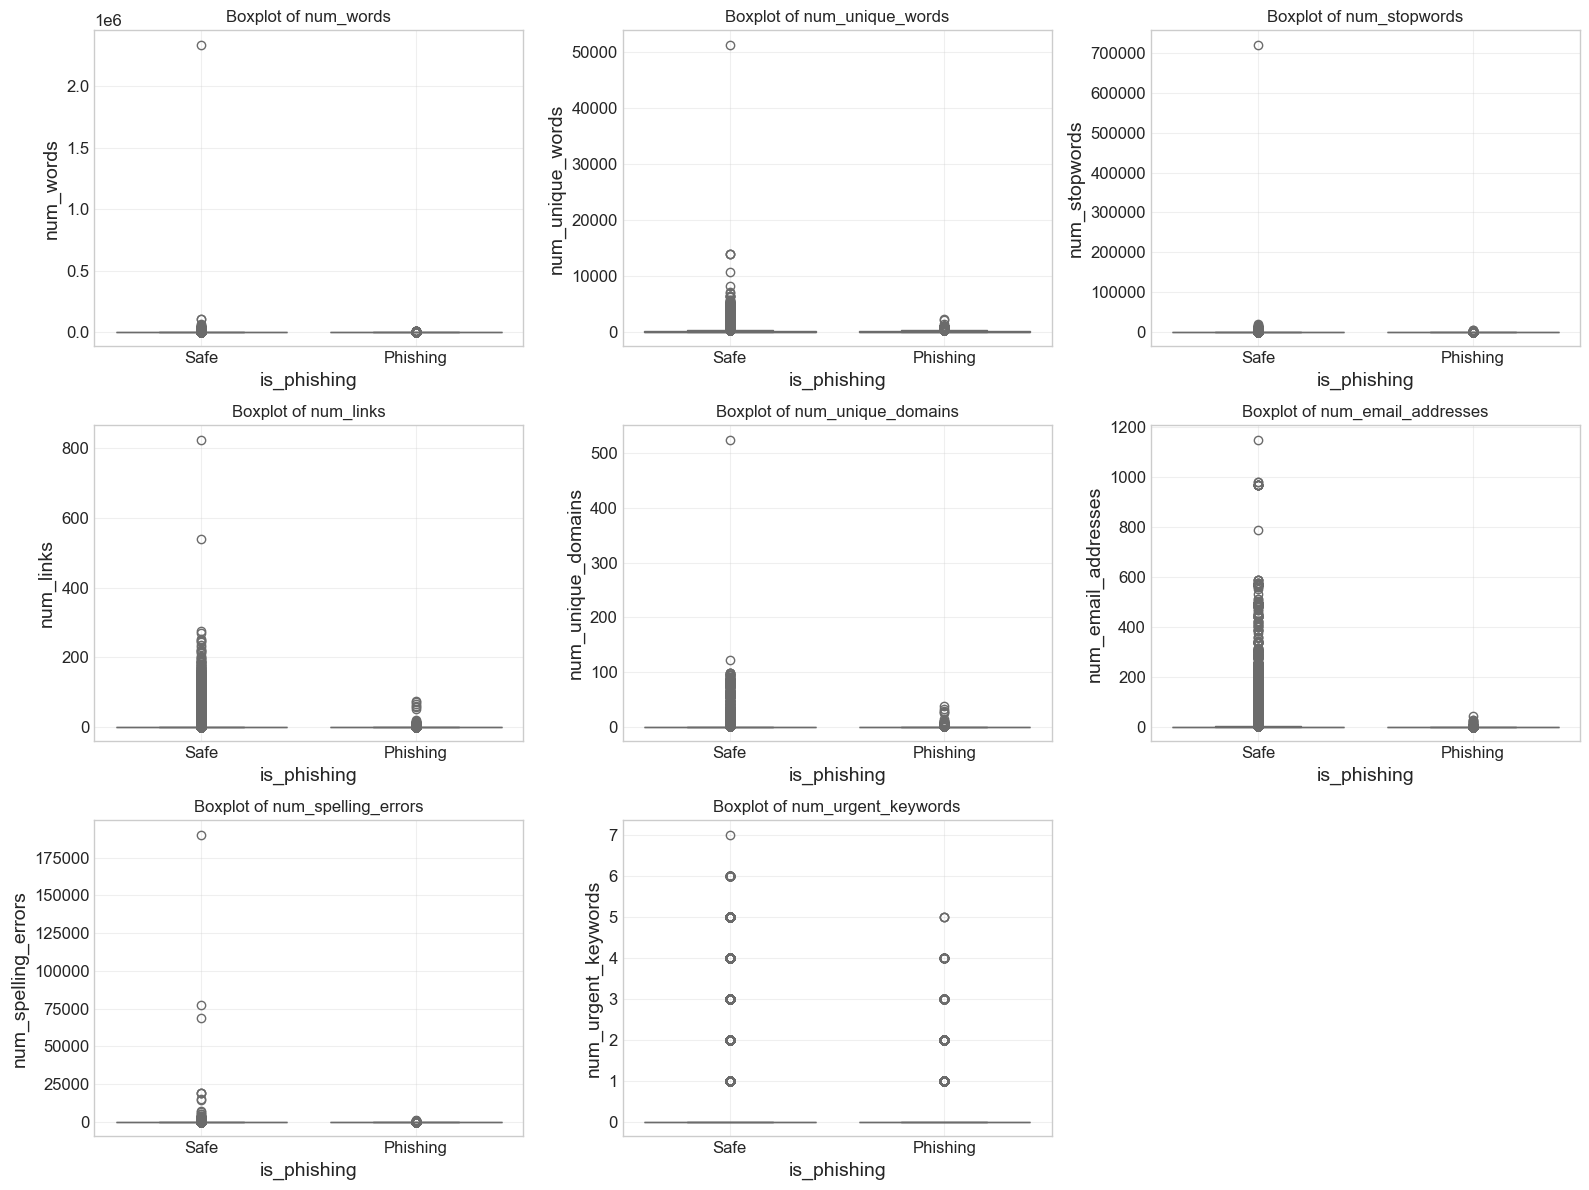

In [8]:
"""Detect and visualize outliers in the dataset using boxplots"""
print("\n=== Outlier Analysis ===")
features = [col for col in df.columns if col not in ['label', 'is_phishing']]
# Calculate IQR for each feature
outlier_counts = {}
for feature in features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    outlier_counts[feature] = len(outliers)
    
    print(f"{feature}: {len(outliers)} outliers detected")

def boxPlotAnalysis(features, df):



    # Create boxplots for each feature comparing classes
    plt.figure(figsize=(16, 12))
    for i, feature in enumerate(features, 1):
        plt.subplot(3, 3, i)
        sns.boxplot(x='is_phishing', y=feature, data=df, palette=['#66b3ff', '#ff9999'])
        plt.title(f'Boxplot of {feature}')
        plt.xticks([0, 1], ['Safe', 'Phishing'])
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('data exploration results/feature_boxplots.png', dpi=300, bbox_inches='tight')
    plt.show()

boxPlotAnalysis(features, df)

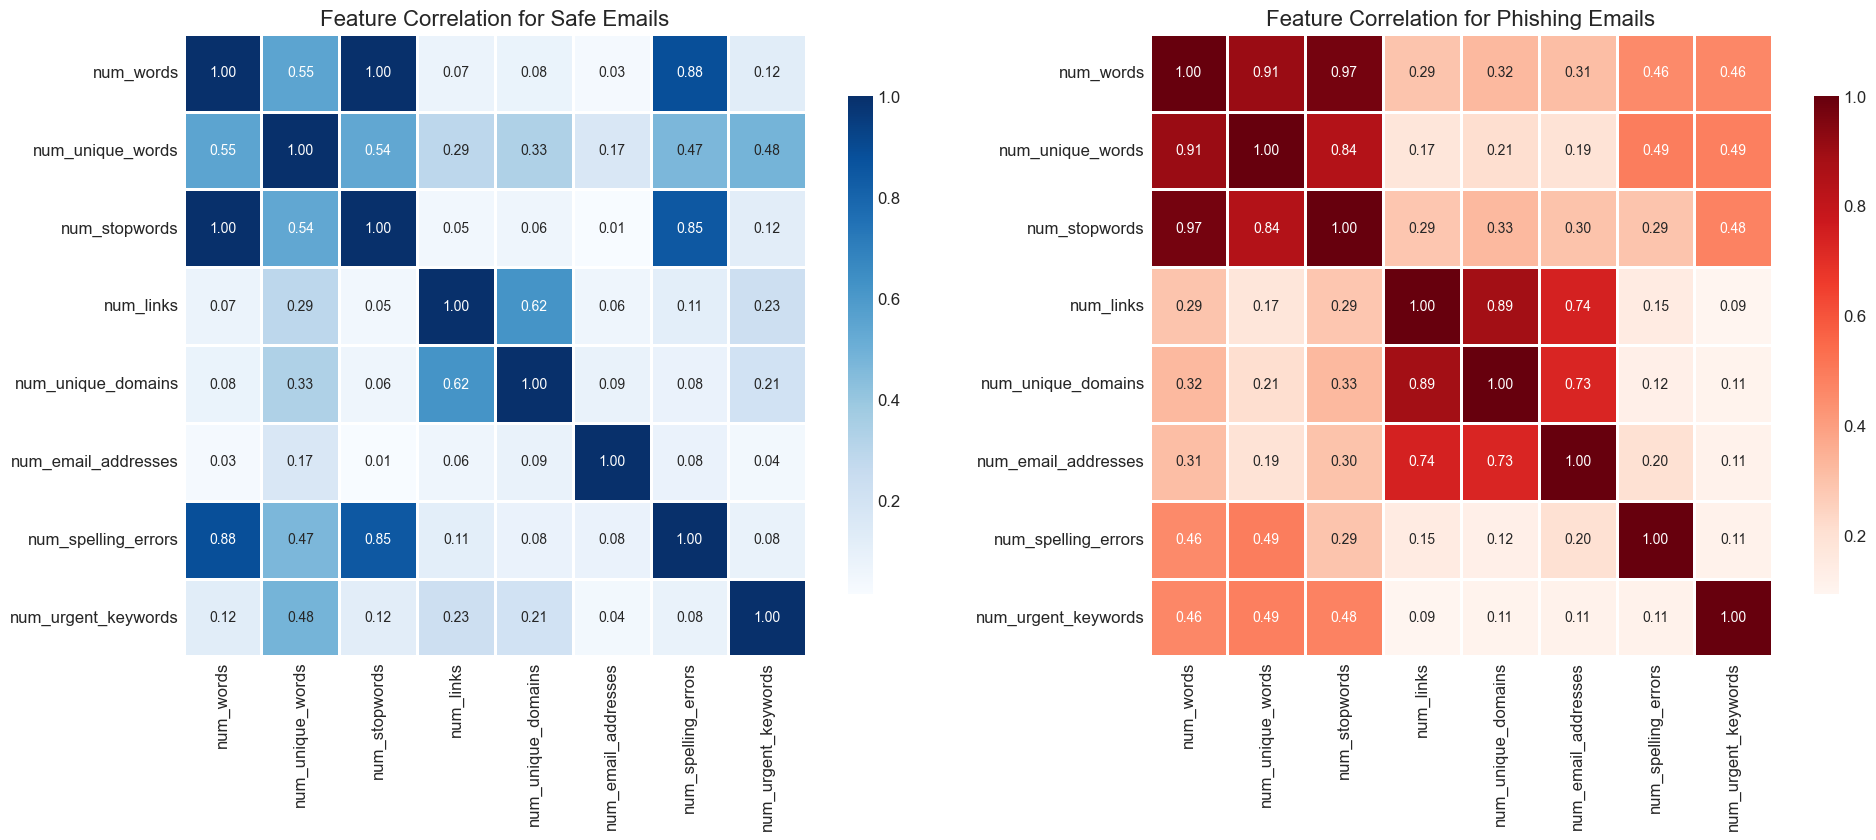


=== Correlation Differences Between Classes ===
Top correlation differences between safe and phishing emails:
num_links vs num_email_addresses: 0.06 (Safe) vs 0.74 (Phishing), Diff: 0.68
num_email_addresses vs num_links: 0.06 (Safe) vs 0.74 (Phishing), Diff: 0.68
num_unique_domains vs num_email_addresses: 0.09 (Safe) vs 0.73 (Phishing), Diff: 0.64
num_email_addresses vs num_unique_domains: 0.09 (Safe) vs 0.73 (Phishing), Diff: 0.64
num_stopwords vs num_spelling_errors: 0.85 (Safe) vs 0.29 (Phishing), Diff: 0.55
num_spelling_errors vs num_stopwords: 0.85 (Safe) vs 0.29 (Phishing), Diff: 0.55
num_words vs num_spelling_errors: 0.88 (Safe) vs 0.46 (Phishing), Diff: 0.43
num_spelling_errors vs num_words: 0.88 (Safe) vs 0.46 (Phishing), Diff: 0.43
num_stopwords vs num_urgent_keywords: 0.12 (Safe) vs 0.48 (Phishing), Diff: 0.36
num_urgent_keywords vs num_stopwords: 0.12 (Safe) vs 0.48 (Phishing), Diff: 0.36


In [9]:
"""Create correlation heatmaps for features separated by target variable"""
features = [col for col in df.columns if col not in ['label', 'is_phishing']]

# Filter dataset by class
safe_emails = df[df['is_phishing'] == False][features]
phishing_emails = df[df['is_phishing'] == True][features]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Correlation heatmap for safe emails
corr_safe = safe_emails.corr()
sns.heatmap(corr_safe, annot=True, cmap='Blues', fmt='.2f', ax=ax1, 
            linewidths=1, square=True, cbar_kws={"shrink": .8})
ax1.set_title('Feature Correlation for Safe Emails', fontsize=16)

# Correlation heatmap for phishing emails
corr_phish = phishing_emails.corr()
sns.heatmap(corr_phish, annot=True, cmap='Reds', fmt='.2f', ax=ax2, 
            linewidths=1, square=True, cbar_kws={"shrink": .8})
ax2.set_title('Feature Correlation for Phishing Emails', fontsize=16)

plt.tight_layout()
plt.savefig('data exploration results/correlation_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate and print correlation difference
print("\n=== Correlation Differences Between Classes ===")
corr_diff = abs(corr_phish - corr_safe)
# Get top 5 differences
corr_diff_flat = corr_diff.unstack()
corr_diff_flat = corr_diff_flat[corr_diff_flat != 0]  # Remove diagonal
top_diffs = corr_diff_flat.nlargest(10)
print("Top correlation differences between safe and phishing emails:")
for (feat1, feat2), diff in top_diffs.items():
    safe_corr = corr_safe.loc[feat1, feat2]
    phish_corr = corr_phish.loc[feat1, feat2]
    print(f"{feat1} vs {feat2}: {safe_corr:.2f} (Safe) vs {phish_corr:.2f} (Phishing), Diff: {diff:.2f}")



=== Feature Importance Analysis using RandomForestClassifier ===
Feature ranking:
1. num_words (0.2829)
2. num_unique_words (0.2579)
3. num_stopwords (0.2324)
4. num_spelling_errors (0.1762)
5. num_urgent_keywords (0.0176)
6. num_links (0.0118)
7. num_email_addresses (0.0111)
8. num_unique_domains (0.0100)


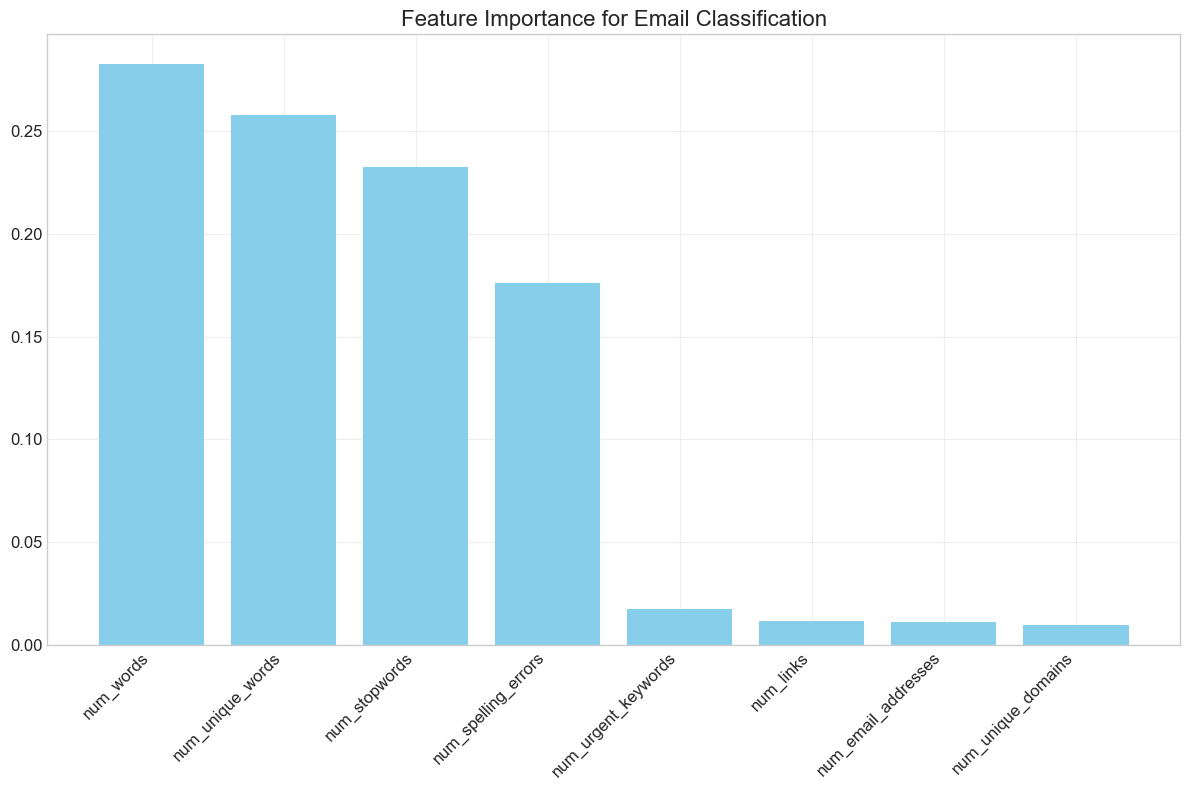

In [10]:
"""Analyze feature importance for distinguishing between classes"""
# using random forest classifier
from sklearn.ensemble import RandomForestClassifier

print("\n=== Feature Importance Analysis using RandomForestClassifier ===")
features = [col for col in df.columns if col not in ['label', 'is_phishing']]
X = df[features]
y = df['is_phishing']

# Train a simple Random Forest to get feature importance
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for i, idx in enumerate(indices):
    print(f"{i+1}. {features[idx]} ({importances[idx]:.4f})")

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.title('Feature Importance for Email Classification', fontsize=16)
plt.bar(range(X.shape[1]), importances[indices], color='skyblue', align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.savefig('data exploration results/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_15240\48174899.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MI Score', y='Feature', data=mi_df, palette='viridis')


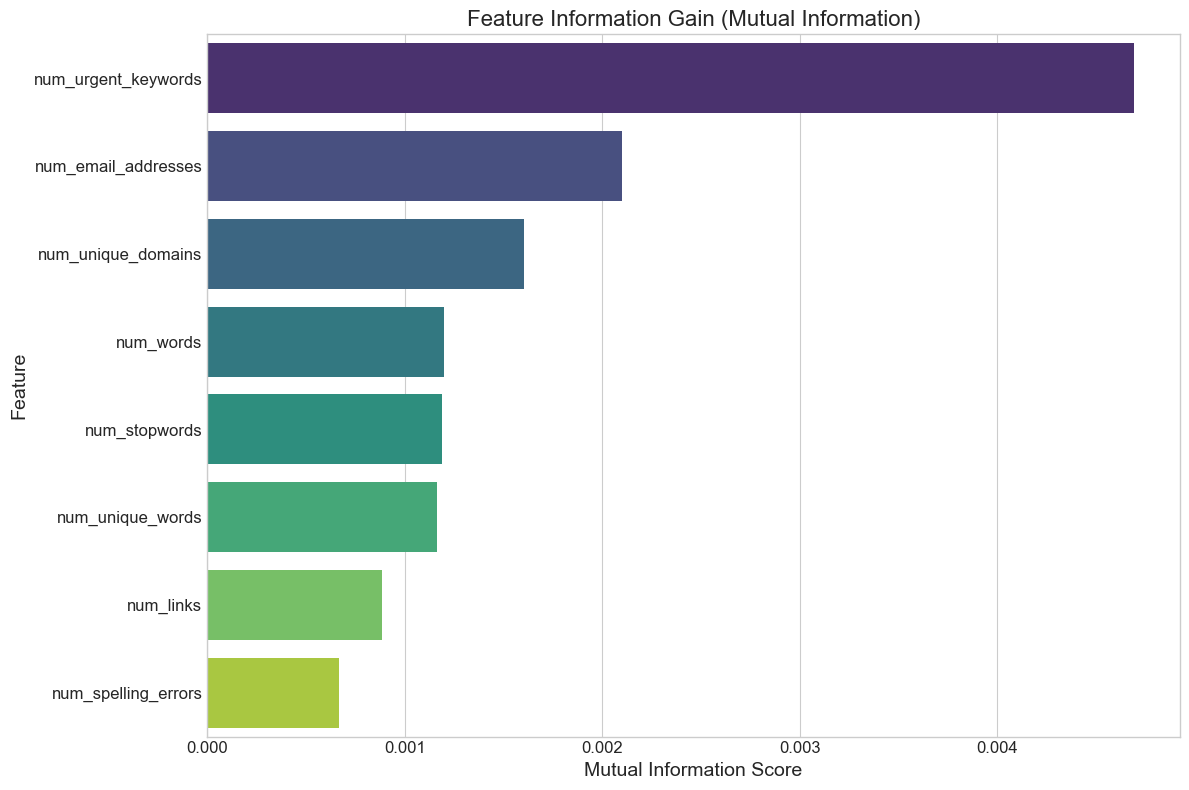

In [11]:
"""Analyze features using information gain / mutual information."""
X = df.drop(['is_phishing'], axis=1)
y = df['is_phishing']
# Calculate mutual information
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values('MI Score', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='MI Score', y='Feature', data=mi_df, palette='viridis')
plt.title('Feature Information Gain (Mutual Information)', fontsize=16)
plt.xlabel('Mutual Information Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.savefig('data exploration results/phishing_information_gain.png', dpi=300, bbox_inches='tight')
plt.show()


End of data exploration

Start of data preparation for training

In [12]:
# this creates a directory for saving models and plots using os
os.makedirs('models', exist_ok = True)
os.makedirs('plots', exist_ok = True)


In [13]:
# this splits the features and target
X = df.drop('is_phishing', axis = 1)
y = df['is_phishing']

# 1. Perform train/validation/test split (70% / 15% / 15%)
# First split into train and temp (temp will be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Then split temp into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Check class distribution in splits
print("\nClass distribution:")
print(f"Training set: {np.bincount(y_train.astype(int))}")
print(f"Validation set: {np.bincount(y_val.astype(int))}")
print(f"Test set: {np.bincount(y_test.astype(int))}")
print(f"Original imbalance ratio: {np.bincount(y.astype(int))[0] / np.bincount(y.astype(int))[1]:.2f}")



Training set: 367392 samples
Validation set: 78727 samples
Test set: 78727 samples

Class distribution:
Training set: [362528   4864]
Validation set: [77684  1043]
Test set: [77685  1042]
Original imbalance ratio: 74.53


In [14]:
#2. Standardize numerical features
print("\nStandardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for later use for training the model
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler saved to models/scaler.pkl")


Standardizing features...
Scaler saved to models/scaler.pkl


In [15]:
# 3. Handle class imbalance using SMOTE (only on training data)
print("\nApplying SMOTE to handle class imbalance...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE - Training samples: {X_train_resampled.shape[0]}")
print(f"After SMOTE - Class distribution: {np.bincount(y_train_resampled.astype(int))}")

# Save preprocessed datasets for model training
print("\nSaving preprocessed datasets...")
np.save('models/X_train_resampled.npy', X_train_resampled)
np.save('models/y_train_resampled.npy', y_train_resampled)
np.save('models/X_val_scaled.npy', X_val_scaled)
np.save('models/y_val.npy', y_val.values)
np.save('models/X_test_scaled.npy', X_test_scaled)
np.save('models/y_test.npy', y_test.values)

print("Preprocessed datasets saved to models/ directory")


Applying SMOTE to handle class imbalance...
After SMOTE - Training samples: 725056
After SMOTE - Class distribution: [362528 362528]

Saving preprocessed datasets...
Preprocessed datasets saved to models/ directory



Visualizing feature distributions after preprocessing...


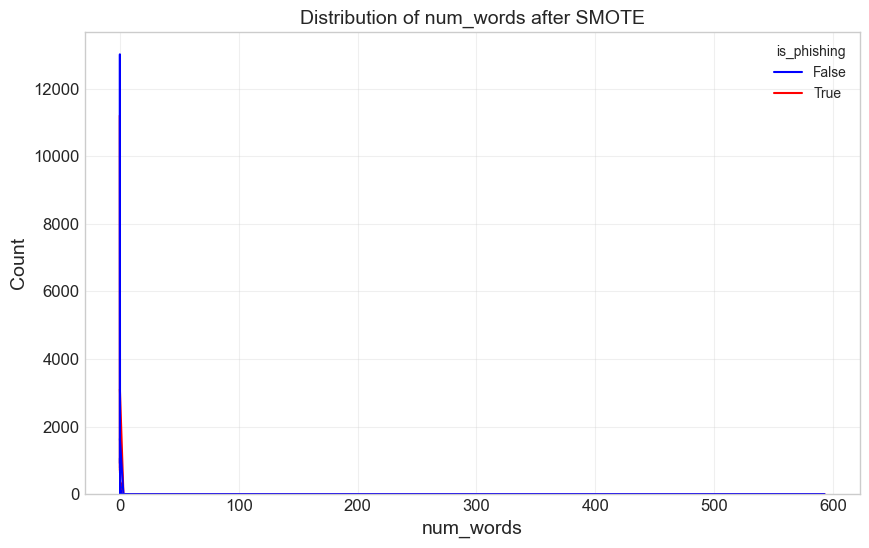

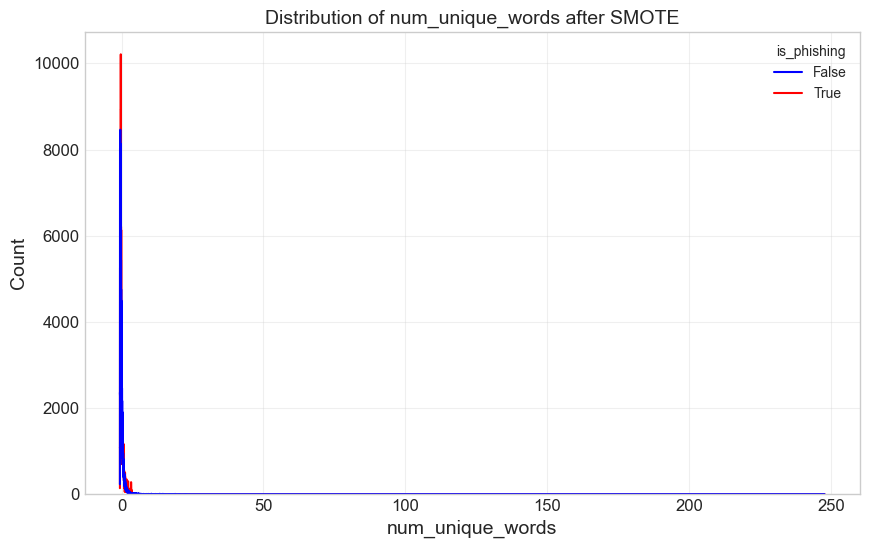

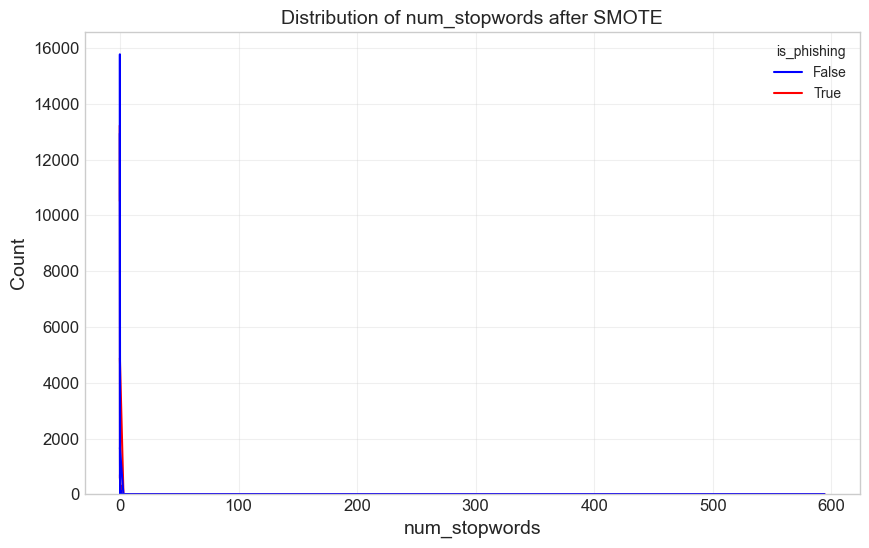

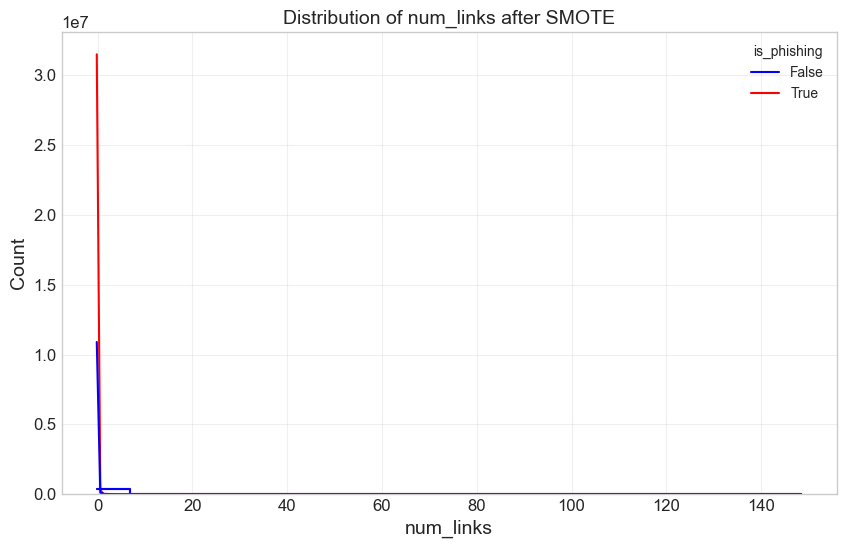

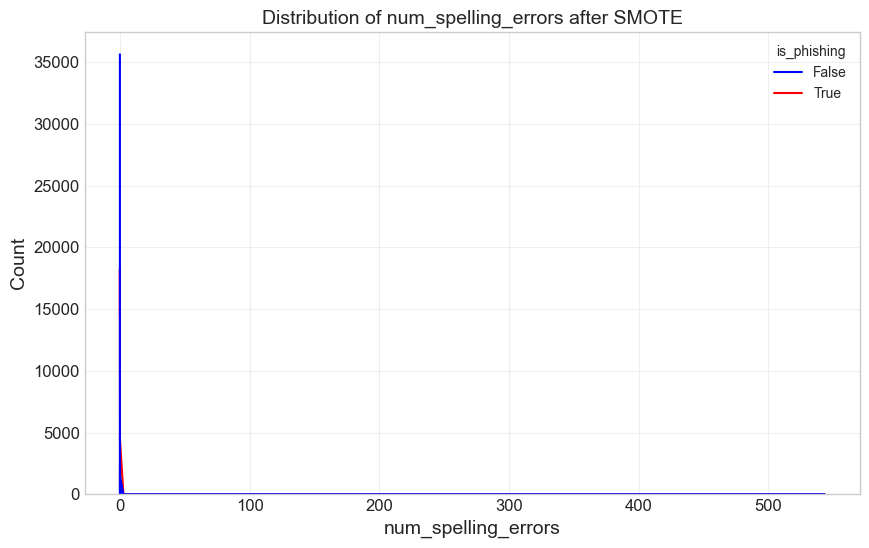

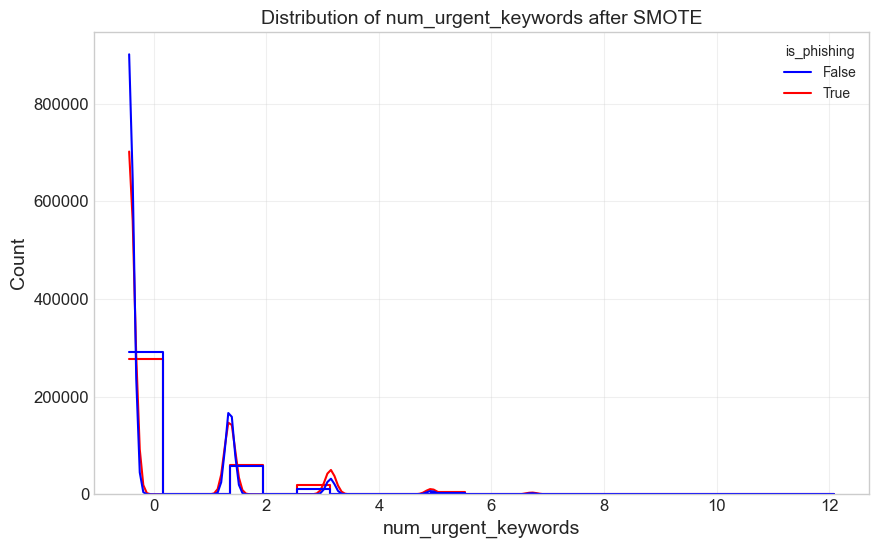

Feature distribution plots saved to plots/ directory


In [16]:
# 4. Visualizing the resampled data 
print("\nVisualizing feature distributions after preprocessing...")

# Convert numpy arrays back to dataframes for easier plotting
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X.columns)
X_train_resampled_df['is_phishing'] = y_train_resampled

# Plot distributions of top features after SMOTE
# top features are based from the data exploration
top_features = ['num_words', 'num_unique_words', 'num_stopwords', 'num_links', 'num_spelling_errors', 'num_urgent_keywords', ] 

for feature in top_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=X_train_resampled_df, x=feature, hue='is_phishing', 
                 kde=True, element='step', palette=['blue', 'red'], 
                 hue_order=[False, True], fill=False)
    plt.title(f'Distribution of {feature} after SMOTE', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.savefig(f'plots/after_smote_{feature}.png', dpi=300, bbox_inches='tight')
    plt.show()

print("Feature distribution plots saved to plots/ directory")

C:\Users\Admin\AppData\Local\Temp\ipykernel_15240\1007727474.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_phishing', y=feature, data=df, palette=['#66b3ff', '#ff9999'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_15240\1007727474.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_phishing', y=feature, data=df, palette=['#66b3ff', '#ff9999'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_15240\1007727474.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_phishing', y=feature, data=df, palette=['#66b3ff', '#ff9999']

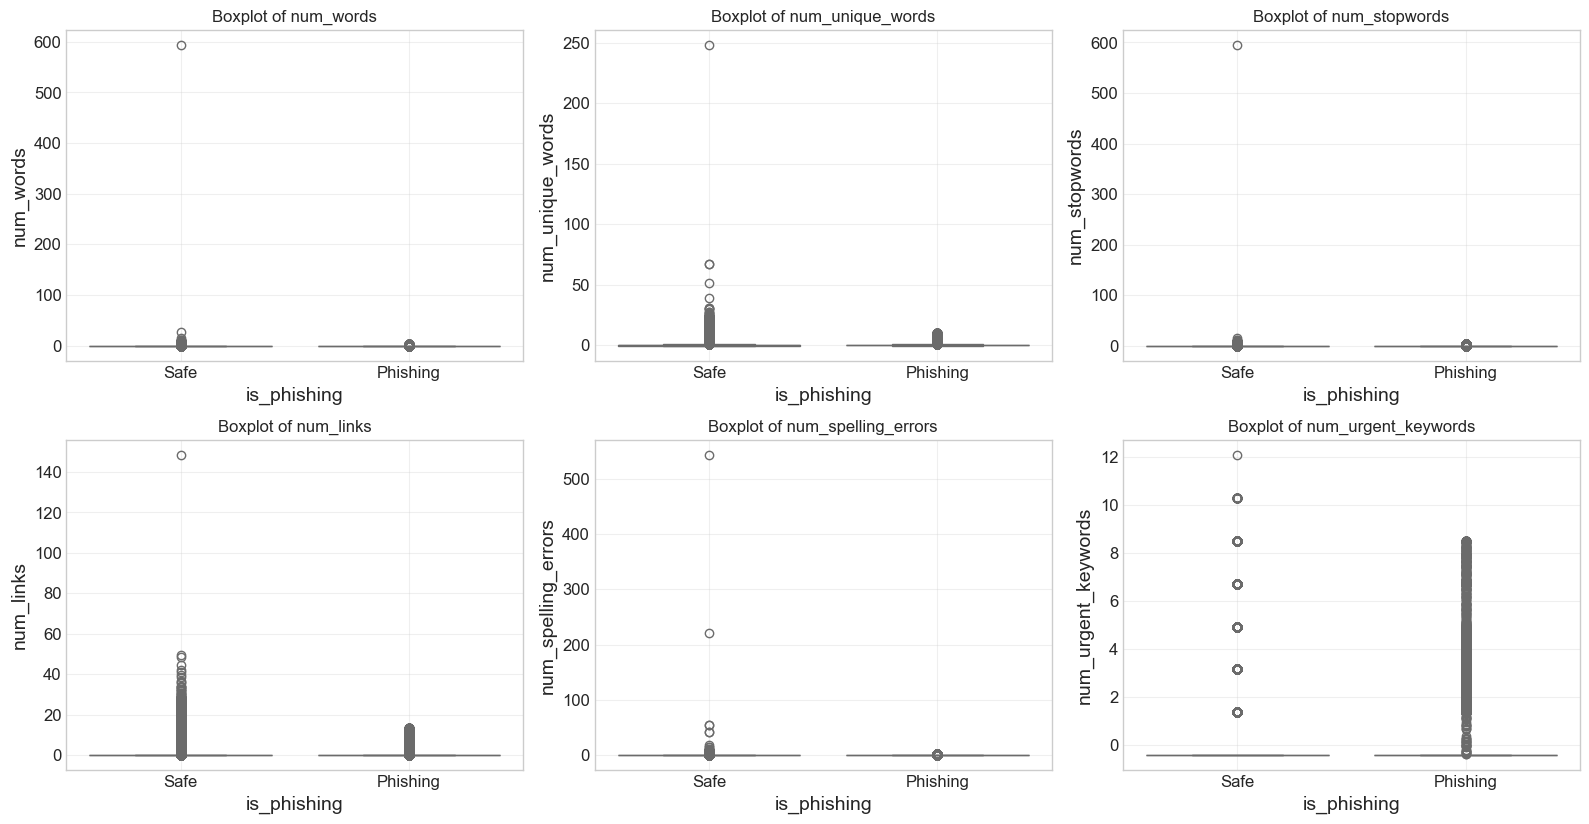

In [17]:
boxPlotAnalysis(top_features, X_train_resampled_df)

End of data preprocessing



Start of data training

In [18]:
# Create directories for results
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Load preprocessed data
print("Loading preprocessed data...")
X_train = np.load('models/X_train_resampled.npy')
y_train = np.load('models/y_train_resampled.npy')
X_val = np.load('models/X_val_scaled.npy')
y_val = np.load('models/y_val.npy')
X_test = np.load('models/X_test_scaled.npy')
y_test = np.load('models/y_test.npy')


Loading preprocessed data...


In [19]:
# Define models to train
models = {
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}


In [20]:
# Define a function for evaluating models
def evaluate_model(model, X, y, model_name, dataset_name):
    """Evaluate model and return metrics"""
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred_proba)
    
    # Create and save confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Safe', 'Phishing'], 
                yticklabels=['Safe', 'Phishing'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name} ({dataset_name})')
    plt.savefig(f'results/{model_name}_{dataset_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create and save ROC curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name} ({dataset_name})')
    plt.legend()
    plt.savefig(f'results/{model_name}_{dataset_name}_roc_curve.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

# Results storage
results = {
    'model': [],
    'train_time': [],
    'cv_accuracy': [],
    'cv_precision': [],
    'cv_recall': [],
    'cv_f1': [],
    'cv_auc': [],
    'val_accuracy': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': [],
    'val_auc': [],
    'test_accuracy': [],
    'test_precision': [],
    'test_recall': [],
    'test_f1': [],
    'test_auc': []
}

In [ ]:
# Define a function for cross-validation
def cross_validate_model(model, X, y, cv, model_name):
    """Perform cross-validation and return average metrics"""
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': []
    }
    
    print(f"Performing {cv.n_splits}-fold cross-validation...")
    fold_num = 1
    
    for train_idx, val_idx in cv.split(X, y):
        X_fold_train, X_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]
        
        # Train the model on this fold
        model_clone = pickle.loads(pickle.dumps(model))  # Create a deep copy of the model
        model_clone.fit(X_fold_train, y_fold_train)
        
        # Get predictions
        y_pred = model_clone.predict(X_fold_val)
        y_pred_proba = model_clone.predict_proba(X_fold_val)[:, 1]
        
        # Calculate metrics
        fold_metrics['accuracy'].append(accuracy_score(y_fold_val, y_pred))
        fold_metrics['precision'].append(precision_score(y_fold_val, y_pred))
        fold_metrics['recall'].append(recall_score(y_fold_val, y_pred))
        fold_metrics['f1'].append(f1_score(y_fold_val, y_pred))
        fold_metrics['auc'].append(roc_auc_score(y_fold_val, y_pred_proba))
        
        print(f"  Fold {fold_num}: Accuracy={fold_metrics['accuracy'][-1]:.4f}, F1={fold_metrics['f1'][-1]:.4f}")
        fold_num += 1
    
    # Calculate average metrics across folds
    avg_metrics = {metric: np.mean(scores) for metric, scores in fold_metrics.items()}
    std_metrics = {metric: np.std(scores) for metric, scores in fold_metrics.items()}
    
    print(f"CV Results for {model_name}:")
    for metric in avg_metrics:
        print(f"  {metric.capitalize()}: {avg_metrics[metric]:.4f} (±{std_metrics[metric]:.4f})")
    
    return avg_metrics

# Train and evaluate each model
print("\nTraining and evaluating models...")
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Model: {name}")
    print(f"{'='*50}")
    
    # Setup cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Perform cross-validation on training data
    start_time = time.time()
    cv_metrics = cross_validate_model(model, X_train, y_train, skf, name)
    cv_time = time.time() - start_time
    print(f"Cross-validation completed in {cv_time:.2f} seconds")
    
    # Train final model on the whole training set
    print(f"Training final {name} model on full training set...")
    model_final = pickle.loads(pickle.dumps(model))  # Create a deep copy
    start_time = time.time()
    model_final.fit(X_train, y_train)
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")
    
    # Save the final model
    with open(f'models/{name.lower().replace(" ", "_")}_model.pkl', 'wb') as f:
        pickle.dump(model_final, f)
    print(f"Model saved to models/{name.lower().replace(' ', '_')}_model.pkl")
    
    # Evaluate on validation set
    print(f"Evaluating {name} on validation set...")
    val_metrics = evaluate_model(model_final, X_val, y_val, name, 'validation')
    
    # Evaluate on test set
    print(f"Evaluating {name} on test set...")
    test_metrics = evaluate_model(model_final, X_test, y_test, name, 'test')
    
    # Store results
    results['model'].append(name)
    results['train_time'].append(train_time)
    results['cv_accuracy'].append(cv_metrics['accuracy'])
    results['cv_precision'].append(cv_metrics['precision'])
    results['cv_recall'].append(cv_metrics['recall'])
    results['cv_f1'].append(cv_metrics['f1'])
    results['cv_auc'].append(cv_metrics['auc'])
    results['val_accuracy'].append(val_metrics['accuracy'])
    results['val_precision'].append(val_metrics['precision'])
    results['val_recall'].append(val_metrics['recall'])
    results['val_f1'].append(val_metrics['f1'])
    results['val_auc'].append(val_metrics['auc'])
    results['test_accuracy'].append(test_metrics['accuracy'])
    results['test_precision'].append(test_metrics['precision'])
    results['test_recall'].append(test_metrics['recall'])
    results['test_f1'].append(test_metrics['f1'])
    results['test_auc'].append(test_metrics['auc'])
    
    print(f"{name} evaluation completed.")
    print(f"CV: Accuracy={cv_metrics['accuracy']:.4f}, Precision={cv_metrics['precision']:.4f}, "
          f"Recall={cv_metrics['recall']:.4f}, F1={cv_metrics['f1']:.4f}, AUC={cv_metrics['auc']:.4f}")
    print(f"Validation: Accuracy={val_metrics['accuracy']:.4f}, Precision={val_metrics['precision']:.4f}, "
          f"Recall={val_metrics['recall']:.4f}, F1={val_metrics['f1']:.4f}, AUC={val_metrics['auc']:.4f}")
    print(f"Test: Accuracy={test_metrics['accuracy']:.4f}, Precision={test_metrics['precision']:.4f}, "
          f"Recall={test_metrics['recall']:.4f}, F1={test_metrics['f1']:.4f}, AUC={test_metrics['auc']:.4f}")

# Create results DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('results/model_comparison.csv', index=False)
print("\nResults saved to results/model_comparison.csv")



Training and evaluating models...

Model: Naive Bayes
Performing 5-fold cross-validation...
  Fold 1: Accuracy=0.5421, F1=0.6790
  Fold 2: Accuracy=0.5426, F1=0.6791
  Fold 3: Accuracy=0.5430, F1=0.6793
  Fold 4: Accuracy=0.5494, F1=0.6793
  Fold 5: Accuracy=0.5424, F1=0.6790
CV Results for Naive Bayes:
  Accuracy: 0.5439 (±0.0028)
  Precision: 0.5238 (±0.0017)
  Recall: 0.9653 (±0.0056)
  F1: 0.6791 (±0.0001)
  Auc: 0.6257 (±0.0035)
Cross-validation completed in 1.75 seconds
Training final Naive Bayes model on full training set...
Training completed in 0.13 seconds
Model saved to models/naive_bayes_model.pkl
Evaluating Naive Bayes on validation set...
Evaluating Naive Bayes on test set...
Naive Bayes evaluation completed.
CV: Accuracy=0.5439, Precision=0.5238, Recall=0.9653, F1=0.6791, AUC=0.6257
Validation: Accuracy=0.1289, Precision=0.0145, Recall=0.9703, F1=0.0287, AUC=0.6244
Test: Accuracy=0.1274, Precision=0.0144, Recall=0.9635, F1=0.0284, AUC=0.6244

Model: SVM
Performing 5-fol

In [ ]:
# Visualize model comparison
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
for metric in metrics:
    plt.figure(figsize=(14, 7))
    x = np.arange(len(results['model']))
    width = 0.25  # Narrower bars to fit three sets
    
    plt.bar(x - width, results_df[f'cv_{metric}'], width, label='Cross-Validation')
    plt.bar(x, results_df[f'val_{metric}'], width, label='Validation')
    plt.bar(x + width, results_df[f'test_{metric}'], width, label='Test')
    
    plt.xlabel('Models')
    plt.ylabel(metric.capitalize())
    plt.title(f'Model Comparison - {metric.capitalize()}')
    plt.xticks(x, results_df['model'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'results/model_comparison_{metric}.png', dpi=300, bbox_inches='tight')
    plt.close()  

# Also create a single comprehensive plot showing F1 scores across all evaluation methods
plt.figure(figsize=(15, 8))
x = np.arange(len(results['model']))
width = 0.25

plt.bar(x - width, results_df['cv_f1'], width, label='CV F1 Score')
plt.bar(x, results_df['val_f1'], width, label='Validation F1 Score')
plt.bar(x + width, results_df['test_f1'], width, label='Test F1 Score')

# Add a horizontal line showing the average CV F1 score
avg_cv_f1 = np.mean(results_df['cv_f1'])
plt.axhline(y=avg_cv_f1, color='r', linestyle='--', label=f'Avg CV F1: {avg_cv_f1:.4f}')

plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('Comprehensive F1 Score Comparison Across Evaluation Methods')
plt.xticks(x, results_df['model'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('results/comprehensive_f1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nModel comparison visualizations saved to results/ directory")
print("\nTraining and evaluation complete!")